# Poker Cards

## Setup

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [1]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

In [1]:
import os
id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = str(id)

In [2]:
from roboflow import Roboflow

ROBOFLOW_API_KEY = '0AxpI0Gl26sKtyMmlfaH'
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [3]:
!wc -l {dataset.location}/dataset/_annotations.train.jsonl
!wc -l {dataset.location}/dataset/_annotations.test.jsonl

810 /home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/poker-cards-4/dataset/_annotations.train.jsonl
43 /home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/poker-cards-4/dataset/_annotations.test.jsonl


In [4]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"IMG_20220316_171834_jpg.rf.e47caf15cb1fbb80014a322084ebc1ec.jpg","prefix":"detect 10 of clubs ; 10 of diamonds ; 10 of hearts ; 10 of spades ; 2 of clubs ; 2 of diamonds ; 2 of hearts ; 2 of spades ; 3 of clubs ; 3 of diamonds ; 3 of hearts ; 3 of spades ; 4 of clubs ; 4 of diamonds ; 4 of hearts ; 4 of spades ; 5 of clubs ; 5 of diamonds ; 5 of hearts ; 5 of spades ; 6 of clubs ; 6 of diamonds ; 6 of hearts ; 6 of spades ; 7 of clubs ; 7 of diamonds ; 7 of hearts ; 7 of spades ; 8 of clubs ; 8 of diamonds ; 8 of hearts ; 8 of spades ; 9 of clubs ; 9 of diamonds ; 9 of hearts ; 9 of spades ; ace of clubs ; ace of diamonds ; ace of hearts ; ace of spades ; jack  of clubs ; jack of diamonds ; jack of hearts ; jack of spades ; king of clubs ; king of diamonds ; king of hearts ; king of spades ; queen of clubs ; queen of diamonds ; queen of hearts ; queen of spades","suffix":"<loc0401><loc0722><loc0702><loc1013> 5 of clubs ; <loc0214><loc0088><loc0529><loc0316> 6 of clubs ; <loc0

### Set up and test data loaders

In [ ]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [ ]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.train.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.valid.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
test_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.test.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)


['brick kilns with chimney', 'background']


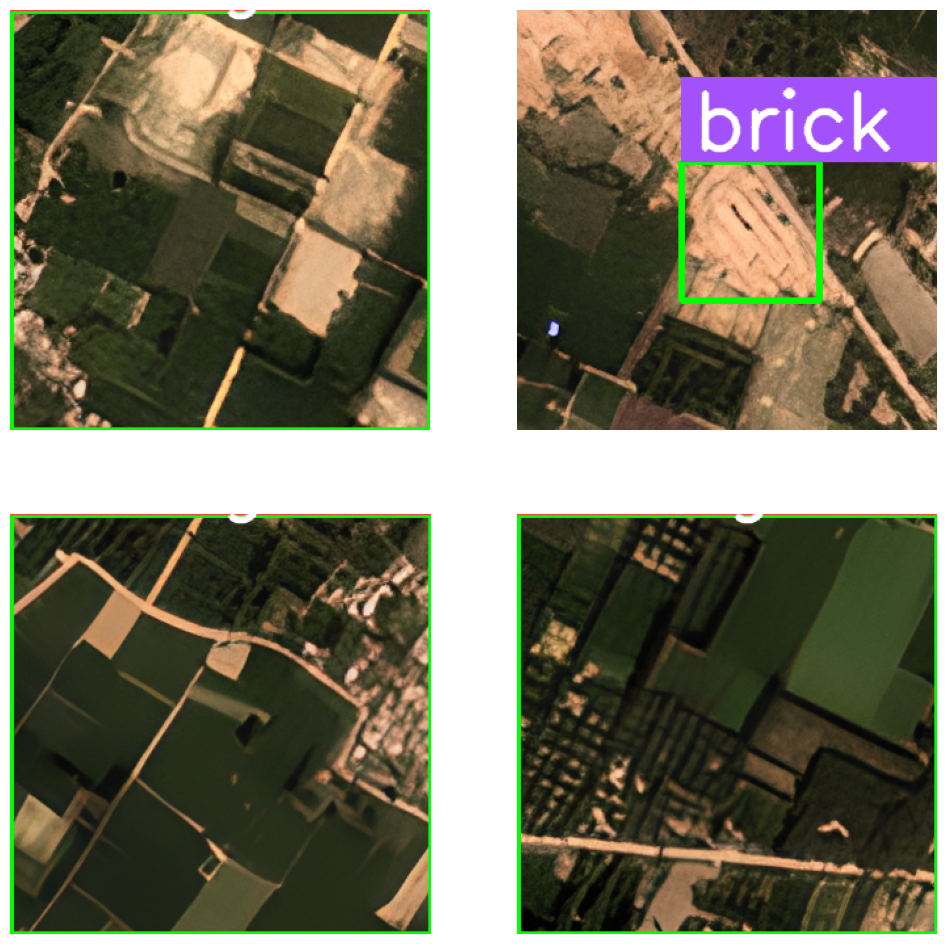

In [6]:
from tqdm import tqdm
import supervision as sv


CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")
print(CLASSES)
images = []
for i in range(4):
    image, label = train_dataset[i]
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label["suffix"],
        resolution_wh=(image.width, image.height),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4, color=sv.Color(r=0, g=255, b=0)).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (2, 2))

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [7]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-448"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [9]:
# @title Freeze the image encoder


# TORCH_DTYPE = torch.bfloat16

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

In [10]:
# @title Fine-tune the entire model with LoRA and QLoRA

from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto", quantization_config = bnb_config, torch_dtype = torch.bfloat16)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


### Fine-tune PaliGemma2 on custom object detection dataset

In [ ]:
from transformers import Trainer, TrainingArguments


def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=10,
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=10,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,  # checkpoint is saved after every 1000 steps
    save_total_limit=1,
    output_dir="paligemma2_object_detection", # model predictions and checkpoint will be present
    bf16=True,
    # report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [13]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: shataxi-dubey (shataxi). Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=0, training_loss=6470.043182373047, metrics={'train_runtime': 27.328, 'train_samples_per_second': 6.953, 'train_steps_per_second': 0.366, 'total_flos': 1853694120718080.0, 'train_loss': 6470.043182373047, 'epoch': 0})

### Run inference with fine-tuned PaliGemma2 model

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


<loc0162><loc0170><loc0493><loc0477> 10 of clubs ; <loc0496><loc0431><loc0880><loc0818> 5 of diamonds ; <loc0496><loc0431><loc0876><loc0806> 5 of diamonds ; <loc0496><loc0115><loc0820><loc0438> 5 of diamonds ; <loc0097><loc0477><loc0393><loc0841> 6 of clubs ; <loc0162><loc0170><loc0486><loc0477> 10 of clubs ; <loc0496><loc0431><loc0876><loc0748> 5 of diamonds ; <loc0496><loc0431><loc0876><loc0751> 5 of diamonds ; <loc0496><loc0115><loc0821><loc0438> 5 of diamonds ; <loc0500><loc0431><loc0876><loc0751> 5 of diamonds ; <loc0500><loc0438><loc0876><loc0820> 5 of diamonds ; <loc0500><loc0438><loc0874><loc0820> 5 of diamonds ; <loc0500><loc0438><loc0869><loc0703> 5 of diamonds ; <loc0500><loc0438><loc0874><loc0748> 5 of diamonds ; <loc0500><loc0438><loc0874><loc0751> 5 of diamonds ; <loc0496><loc0438><loc0876><loc0751> 5 of diamonds ; <loc0496><loc0438><loc0876><loc0748> 5 of diamonds ; <loc0496><loc0444><loc0874><loc0725> 5 of diamonds ; <loc0496><loc0438><loc0876><loc0725> 5 of diamonds ; 

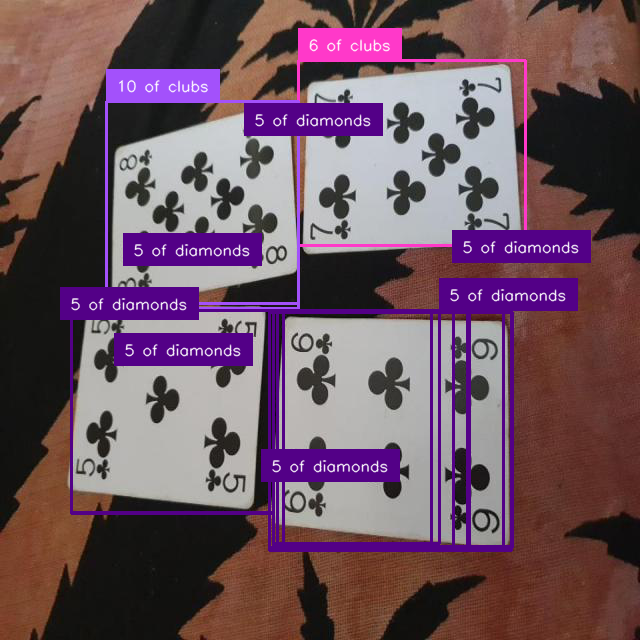

In [ ]:
image, label = test_dataset[1]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]

inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

w, h = image.size
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
annotated_image

### Evaluate fine-tuned PaliGemma2 model

In [ ]:
import numpy as np
from tqdm import tqdm

images = []
targets = []
predictions = []

with torch.inference_mode():
    for i in tqdm(range(len(test_dataset))):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        w, h = image.size
        prediction = sv.Detections.from_lmm(
            lmm='paligemma',
            result=generated_text,
            resolution_wh=(w, h),
            classes=CLASSES)

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = sv.Detections.from_lmm(
            lmm='paligemma',
            result=suffix,
            resolution_wh=(w, h),
            classes=CLASSES)

        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        images.append(image)
        targets.append(target)
        predictions.append(prediction)

100%|██████████| 44/44 [13:17<00:00, 18.13s/it]


In [ ]:
# @title Calculate mAP

from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.0024
mAP @ 50:    0.0035
mAP @ 75:    0.0034
mAP scores: [0.0035159  0.0035159  0.0035159  0.00344909 0.00344909 0.00344909
 0.0031029  0.00024685 0.00018119 0.        ]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  2: [0.00341413 0.00341413 0.00341413 0.00341413 0.00341413 0.00341413
 0.00341413 0.00341413 0.         0.        ]
  3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  5: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  6: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  8: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  9: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  10: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  11: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  12: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  13: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  14: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  15: [0. 0.

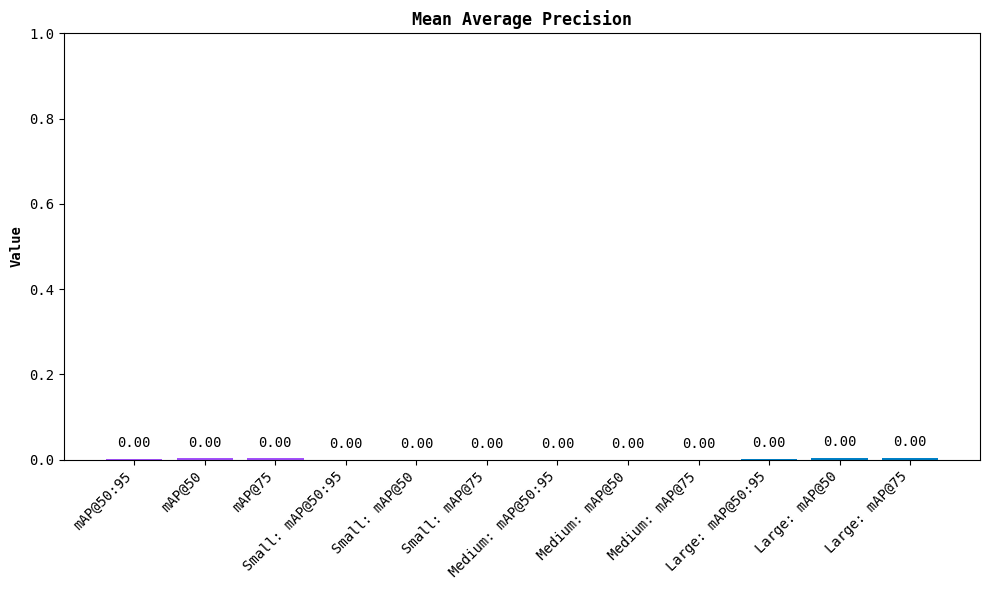

In [ ]:
map_result.plot()

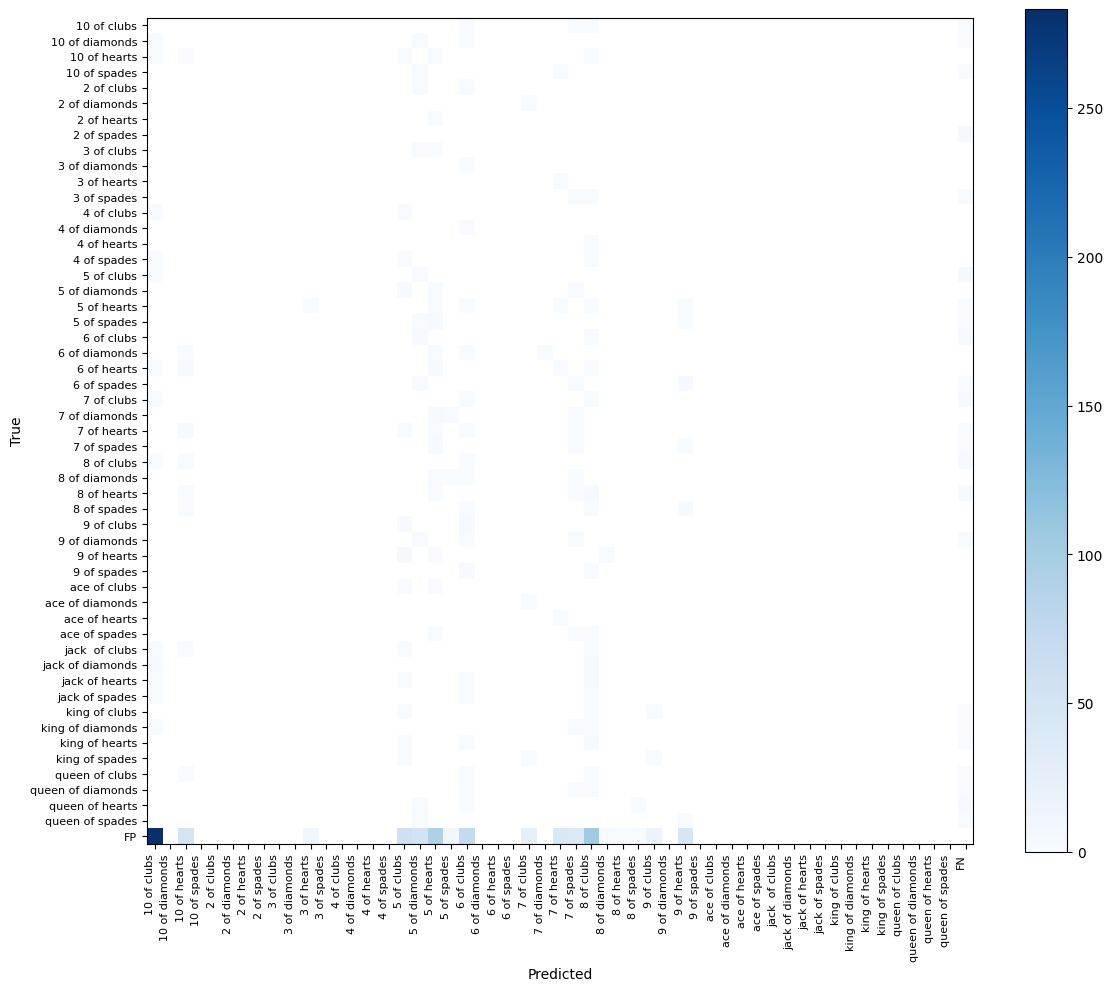

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

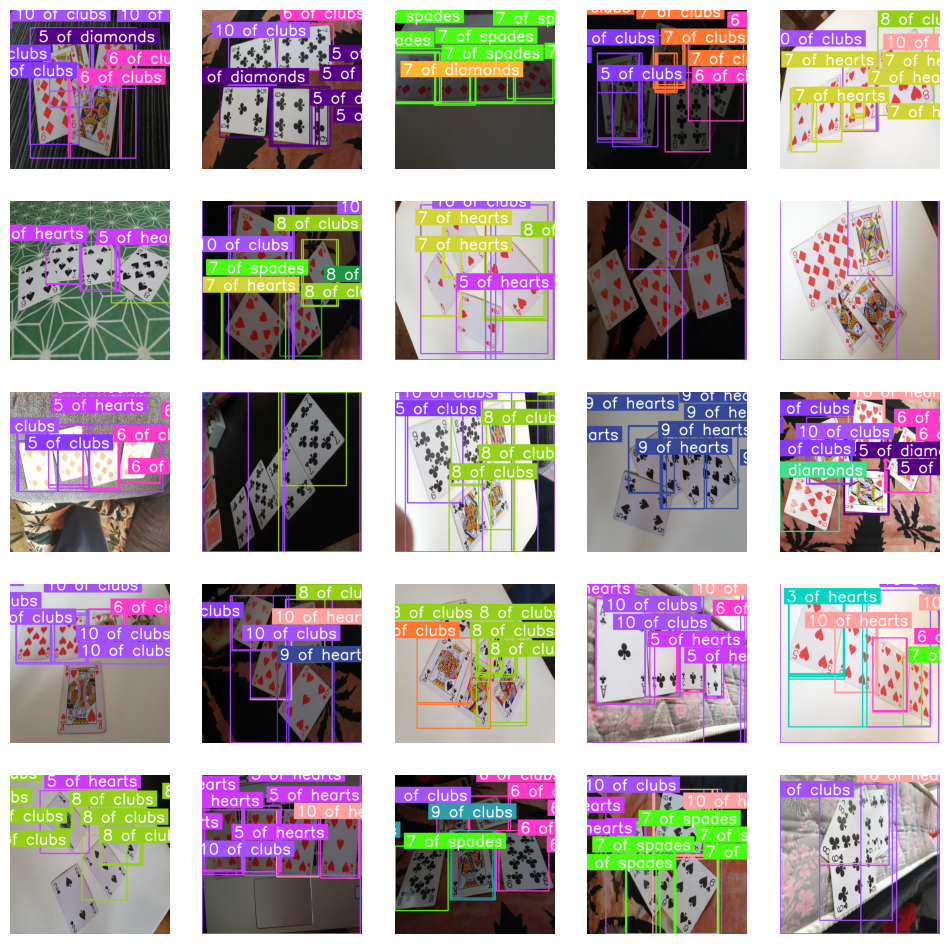

In [ ]:
annotated_images = []

for i in range(25):
    image = images[i]
    detections = predictions[i]

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=4).annotate(annotated_image, detections)
    annotated_image = sv.LabelAnnotator(text_scale=2, text_thickness=4, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5, 5))